# 📊 Segmentación de Clientes con K-Means

Este notebook muestra cómo aplicar **K-Means** para segmentar clientes de un shopping usando el clásico dataset **Mall_Customers**.  
Se exploran métricas, visualizaciones y buenas prácticas para elegir el número óptimo de clusters.

---

## 🚀 Pasos principales

### 1. Carga y exploración de datos
- Se importa el dataset.
- Se realiza un análisis exploratorio con **ydata-profiling**.

### 2. Preprocesamiento
- Se eliminan columnas irrelevantes (`Gender`, `CustomerID`).
- Se revisa la estructura de los datos.

### 3. Selección del número de clusters
Se prueban distintos valores de **K (2 a 10)** y se comparan métricas como:

- **WCSS** (Elbow method)  
- **Silhouette Score**  
- **Calinski-Harabasz**  
- **Davies-Bouldin**  

![Elbow Method](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png)

### 4. Visualización de resultados
- Se grafican los clusters y centroides en **3D con Plotly**.  
- Los clientes se agrupan según: **Edad**, **Ingresos** y **Score de gasto**.

### 5. Asignación y análisis de clusters
- Se agrega la clasificación al dataset.  
- Se analiza la cantidad de clientes por grupo.

---


In [1]:
# ALGUNOS LINKS INTERESANTES
# Sección de sklearn sobre Clustering
# https://scikit-learn.org/stable/modules/clustering.html#clustering
# habla un poco más sobre el método del codo y de la silueta
# https://machinelearningparatodos.com/segmentacion-utilizando-k-means-en-python/
# Para qué segmentar clientes desde punto de vista del marketing
# https://datapeaker.com/big-data/resuelva-la-segmentacion-de-clientes-con-aprendizaje-automatico/
# Animación que ilustra como el algoritmo hace la segmentación
# https://miro.medium.com/max/617/1*pwCAVEzTCi22Ihto234ZlA.gif
# Documentación oficial de SkLearn sobre Kmeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# cómo rotar el gráfico 3d
# https://stackoverflow.com/questions/49981313/rotate-interactively-a-3d-plot-in-python-matplotlib-jupyter-notebook
# Interesante artículo sobre métricas para determinar el nro de clusters
# https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd


!pip list | grep ydata
!pip list | grep plotly


ydata-profiling                   4.16.1
plotly                            5.24.1


In [2]:
%matplotlib inline

!pip install ydata-profiling

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from ydata_profiling import ProfileReport
#from google.colab import files
import warnings


warnings.filterwarnings('ignore')

In [4]:
df_mall = pd.read_csv('https://raw.githubusercontent.com/palasatenea66/DATASETS/main/Mall_Customers.csv')

print(df_mall.shape)
print(df_mall.columns)
#['CustomerID', 'Gender', 'Age', 'Annual Income (k$)','Spending Score (1-100)']
df_mall

(200, 5)
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [5]:
profile = ProfileReport(df_mall, title="Pandas Profiling Report")
profile.to_file("clientes.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43419.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile

In [7]:
#      en ppio no nos interesan el género ni el número de cliente

df_mall.drop(columns=['Gender', 'CustomerID'], inplace=True)

#    veamos los primeros 5 registros
print(df_mall[:5])



   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


In [8]:
df_mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     200 non-null    int64
 1   Annual Income (k$)      200 non-null    int64
 2   Spending Score (1-100)  200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


# 📘 Selección del número de clusters en K-Means usando métricas de validación

# El coeficiente de silueta importa porque mide qué tan bien están agrupados los datos en cada cluster y qué tan separados están de otros clusters.

Si el coeficiente es alto (cerca de 1), los puntos están bien agrupados y los clusters son claros.
Si es bajo o negativo, los puntos están mal asignados y los clusters se mezclan.
Por eso, al elegir el número de clusters (K), buscamos el valor que maximiza el coeficiente de silueta: así aseguramos que la segmentación sea la más representativa y útil para el análisis.

Este bloque muestra cómo elegir el número óptimo de clusters (**K**) en K-Means utilizando varias métricas de validación sobre el dataset `Mall_Customers`.

---

## 🔎 ¿Por qué elegir K cuidadosamente?

En K-Means, **K** es el número de grupos que queremos encontrar.  
Como no sabemos cuántos grupos hay realmente, probamos varios valores (por ejemplo, de 2 a 10) y analizamos la calidad de cada partición usando diferentes métricas.

---

## ⚙️ Métricas utilizadas

- **WCSS (Within Cluster Sum of Squares):** mide la inercia, o qué tan compactos son los clusters.
- **Silhouette Score:** mide qué tan bien está cada punto dentro de su cluster comparado con los clusters vecinos (más alto = mejor).
- **Calinski-Harabasz:** compara la dispersión entre clusters y dentro de los clusters (más alto = mejor).
- **Davies-Bouldin:** mide la similitud entre clusters (más bajo = mejor).

---

## 🧑‍💻 Visualización de resultados
- Se grafican los valores de cada métrica para todos los K probados.
- El gráfico de silueta ayuda a ver la calidad de los clusters para cada K.
- El método del codo (WCSS) ayuda a identificar el punto donde agregar más clusters deja de mejorar significativamente la agrupación.





For n_clusters=2, The Silhouette Coefficient is 0.293166070535953


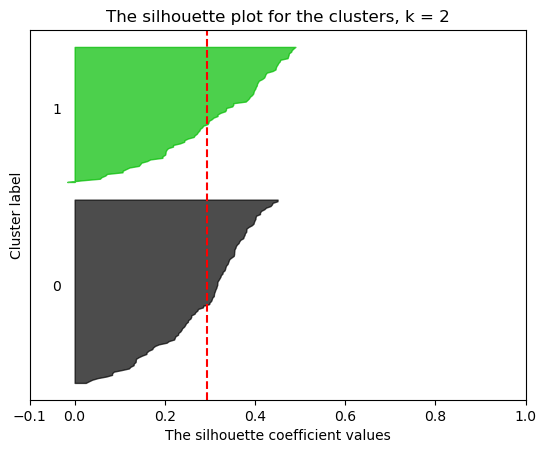



For n_clusters=3, The Silhouette Coefficient is 0.2666851522531476


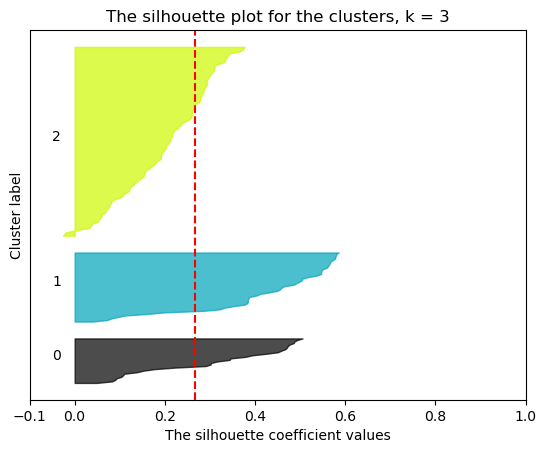



For n_clusters=4, The Silhouette Coefficient is 0.3572611703766717


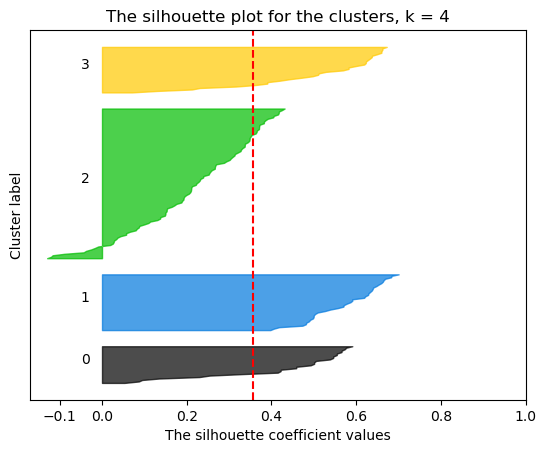



For n_clusters=5, The Silhouette Coefficient is 0.44428597560893024


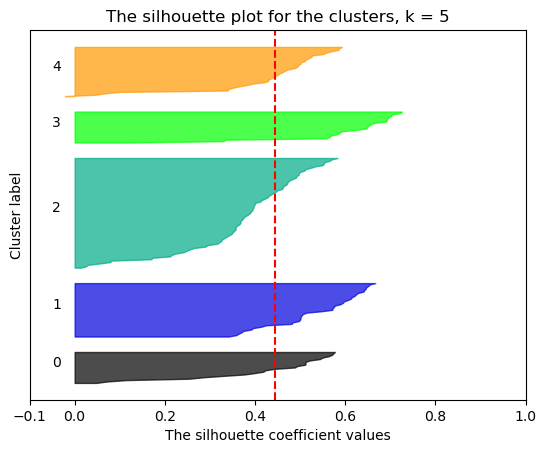



For n_clusters=6, The Silhouette Coefficient is 0.4516490888773576


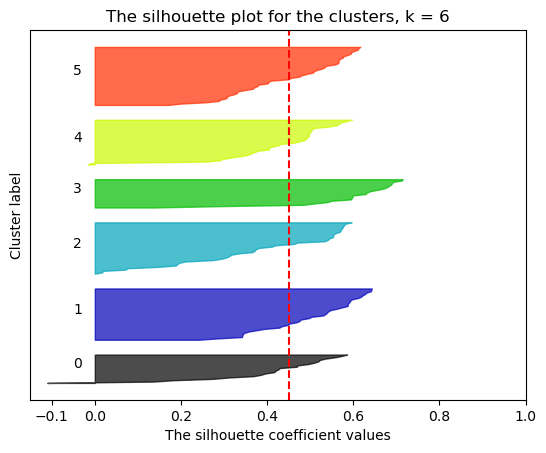



For n_clusters=7, The Silhouette Coefficient is 0.4403208668029096


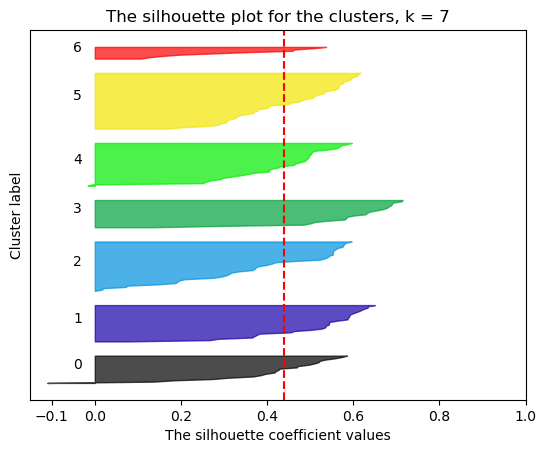



For n_clusters=8, The Silhouette Coefficient is 0.42631940650028766


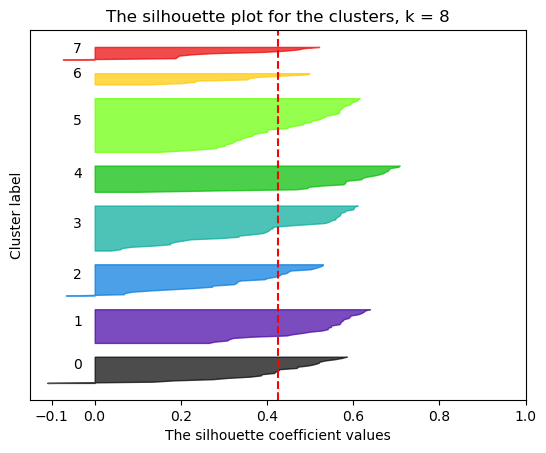



For n_clusters=9, The Silhouette Coefficient is 0.41366816572834864


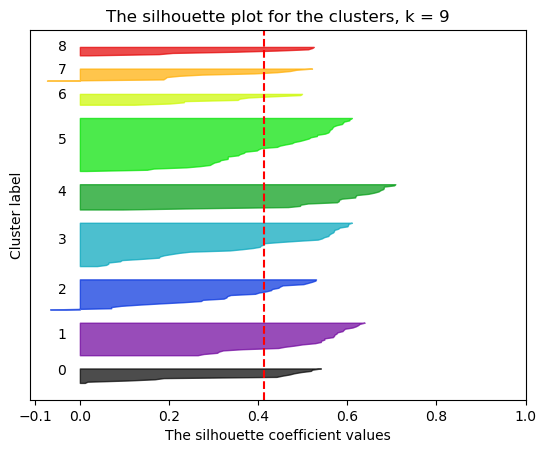



For n_clusters=10, The Silhouette Coefficient is 0.37541598672481286


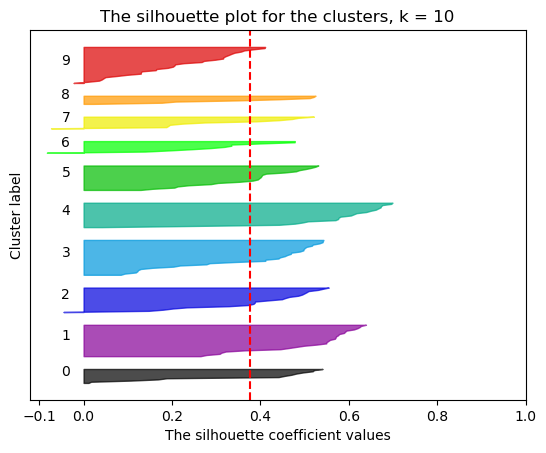

In [9]:
# 📘 Selección del número de clusters en K-Means usando métricas de validación
# Dataset: df_mall (ejemplo clásico de segmentación de clientes en un shopping)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ------------------------------------------------------------------------------------------------
# Listas para guardar las métricas en cada iteración
# ESTAS SON LAS METRICAS QUE SE VAN A USAR
wcss = []       # Within Cluster Sum of Squares (inercia)
calinski = []   # Índice de Calinski-Harabasz
davies = []     # Índice de Davies-Bouldin
# ------------------------------------------------------------------------------------------------

# 🔎 ¿Por qué se hace esto?
# El problema: elegir K (número de clusters).
# En K-Means tenés que decirle al algoritmo cuántos clusters querés (n_clusters).
# Pero en la vida real no sabés cuántos grupos hay en tus datos.
# Entonces se prueban varios valores de K (por ejemplo del 2 al 10) y se compara la calidad de cada partición.

# 🔹 Probar distintos valores de K (desde 2 hasta 10 clusters)
for n_cluster in range(2, 11):
    print('\n')
    # ------------------------------------------------------------------------------------------------
    # Definir modelo KMeans
    
    # ESTA FUNCION PARTICIONA LOS DATOS EN K CLUSTERS
    km = KMeans(n_clusters=n_cluster, init='k-means++', random_state=16) # init='k-means++' es la mejor práctica para inicializar los centroides
    
    # Entrenar modelo y obtener etiquetas de cluster
    preds = km.fit_predict(df_mall)
    
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # - METRICA Silhouette Score 
    # mide qué tan bien está cada punto dentro de su cluster comparado con los clusters vecinos (más alto = mejor).

    # Calcular el coeficiente de silueta promedio
    # Mide qué tan bien esta definido cada punto en su cluster comparado con los clusters vecinos.
    sil_coeff = silhouette_score(df_mall, preds, metric='euclidean')
    print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # - METRICA WCSS (Within Cluster Sum of Squares): mide la inercia, o qué tan compactos son los clusters.
    
    # Guardar métricas
    wcss.append(km.inertia_)  # Inercia: suma de distancias cuadráticas
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # - METRICA Calinski-Harabasz:** compara la dispersión entre clusters y dentro de los clusters (más alto = mejor).
    
    # Compara la dispersión entre clusters y dentro de los clusters.➝ Cuanto más alto, mejor.
    calinski.append(calinski_harabasz_score(df_mall, preds))
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # - METRICA Davies-Bouldin:** mide la similitud entre clusters (más bajo = mejor).
    
    # Mide cuán similares son los clusters entre sí. ➝ Cuanto más bajo, mejor (clusters bien separados).
    davies.append(davies_bouldin_score(df_mall, preds))
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    
    # Calcular valores de silueta para cada muestra individual
    sample_silhouette_values = silhouette_samples(df_mall, preds)

    # 👉 La idea es no quedarse con una sola métrica, sino mirar varias para decidir el mejor K.

    # 🔹 Gráfico de silueta para cada K
    fig = plt.figure()
    y_lower = 10  # espacio inicial para graficar las barras
    
    # Dibujar cada cluster por separado
    for i in range(n_cluster):
        # Extraer los valores de silueta del cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[preds == i]

        # Ordenar los valores (para que se vea prolijo el gráfico)
        ith_cluster_silhouette_values.sort()

        # Calcular el tamaño del cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # DISEñO
        color = cm.nipy_spectral(float(i) / n_cluster)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),  # rango en eje Y
            0,                            # desde 0
            ith_cluster_silhouette_values,# hasta valores de silueta
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # margen de 10 entre clusters

    # Título y ejes del gráfico
    plt.title(f"The silhouette plot for the clusters, k = {n_cluster}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # 🔴 Línea vertical roja → silueta promedio global
    plt.axvline(x=sil_coeff, color="red", linestyle="--")

    # Quitar ticks innecesarios del eje Y
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


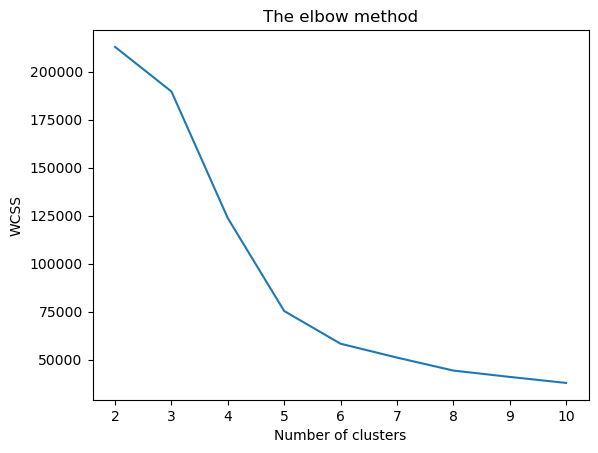

In [10]:
# graficamos el método del codo
plt.plot(range(2,11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')   # within cluster sum of squares
plt.show()


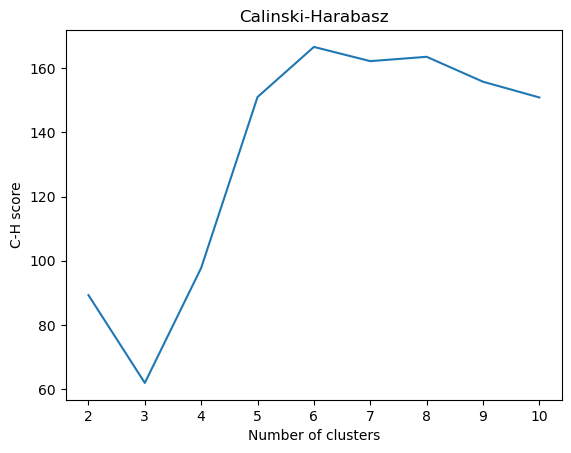

In [11]:
# graficamos Calinski-Harabasz
plt.plot(range(2,11), calinski)
plt.title('Calinski-Harabasz')
plt.xlabel('Number of clusters')
plt.ylabel('C-H score')
plt.show()

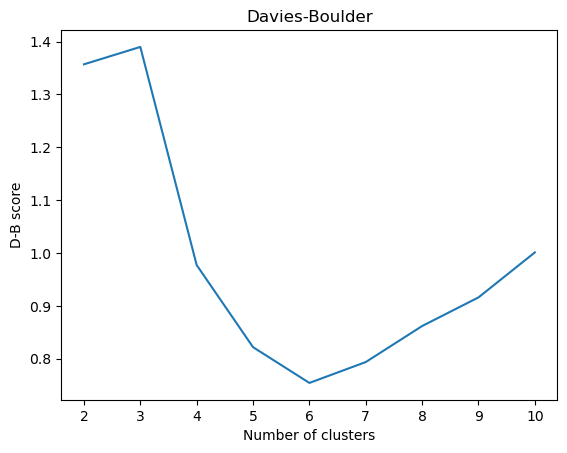

In [12]:
# graficamos Davies-Boulder
plt.plot(range(2,11), davies)
plt.title('Davies-Boulder')
plt.xlabel('Number of clusters')
plt.ylabel('D-B score')
plt.show()

In [13]:
#  planteamos nuestro modelo con 6 clusters y lo hacemos clasificar
# POR QUE 6? POR QUE ES EL QUE MAS COEFICIENTE DIO 0.4516490888773576

km = KMeans(n_clusters=6, n_init=100, max_iter=1000, init='k-means++', random_state=5)

# PRED DEFINE EN QUE CLUSTER (DEL 0 AL 5) PERTENECE CADA CLIENTE
pred = km.fit_predict(df_mall)

#  cómo asignó a los clientes su clase?
print(pred)

[4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4
 5 4 5 2 5 2 1 4 5 2 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 1 2 2 2 2
 2 1 2 1 1 2 2 1 2 2 1 2 2 1 1 2 2 1 2 1 1 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 2
 1 1 1 1 1 2 2 2 2 1 1 1 0 1 0 3 0 3 0 3 0 1 0 3 0 3 0 3 0 3 0 1 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0]


In [17]:
# veamos los centroides
print('                  CENTROIDES')
print('         EDAD        INGRESOS          %GASTADO')

centros=pd.DataFrame(km.cluster_centers_, columns=['Age', 'Annual Income (k$)','Spending Score (1-100)'])
centros

                  CENTROIDES
         EDAD        INGRESOS          %GASTADO


,Age,Annual Income (k$),Spending Score (1-100)
0,32.692308,86.538462,82.128205
1,27.000000,56.657895,49.131579
2,56.155556,53.377778,49.088889
3,41.685714,88.228571,17.285714
4,44.142857,25.142857,19.523810
5,25.272727,25.727273,79.363636


In [22]:
# agregamos la clasificación al dataset y lo dejamos listo para uso posterior
print('      EDAD        INGRESOS          %GASTADO       CLUSTER')

df_mall['preds'] = pred
df_mall

      EDAD        INGRESOS          %GASTADO       CLUSTER


,Age,Annual Income (k$),Spending Score (1-100),preds
0,19,15,39,4
1,21,15,81,5
2,20,16,6,4
3,23,16,77,5
4,31,17,40,4
...,...,...,...,...
195,35,120,79,0
196,45,126,28,3
197,32,126,74,0
198,32,137,18,3


In [16]:
#     veamos cómo quedó la clasificación, usamos plotly para graficar
fig = px.scatter_3d(data_frame=df_mall, x="Age", y="Annual Income (k$)", z= 'Spending Score (1-100)', width=1000, height=800, color=pred)
fig.add_trace(px.scatter_3d(data_frame=centros, x="Age", y="Annual Income (k$)", z= 'Spending Score (1-100)').update_traces(
    marker=dict(size=4, symbol='x', color='black')).data[0]) # centroides
fig.show()



In [23]:
# ¿ Cuántos clientes hay en cada cluster ?
df_mall['preds'].value_counts()

preds
2    45
0    39
1    38
3    35
5    22
4    21
Name: count, dtype: int64

# 🔍 Comparación de Métodos de Clustering: K-Means vs Agglomerative

En este notebook no solo se aplica **K-Means**, sino también **Agglomerative Clustering**.  
Ambos son algoritmos de **aprendizaje no supervisado**, pero funcionan de forma diferente y es útil compararlos.

---

## ⚡ K-Means
- **Idea principal**: asigna los puntos al clúster cuyo **centroide** esté más cercano.  
- **Cómo funciona**:
  1. Elegís un número de clústeres `K`.
  2. Se ubican centroides iniciales.
  3. Cada punto se asigna al centroide más cercano.
  4. Los centroides se recalculan.
  5. El proceso se repite hasta converger.
- **Ventajas**:
  - Rápido y escalable con grandes datasets.
- **Limitaciones**:
  - Necesita definir `K` previamente.
  - Supone que los clústeres son esféricos y de tamaño similar.

---

## 🌳 Agglomerative Clustering (Jerárquico)
- **Idea principal**: comienza con cada punto como un clúster propio y **fusiona iterativamente** los más cercanos hasta llegar a `K`.  
- **Cómo funciona**:
  1. Cada punto es un clúster.
  2. Se calculan distancias entre clústeres.
  3. Se van fusionando los más próximos.
  4. El proceso se detiene cuando quedan `K` grupos.
- **Parámetros importantes**:
  - `n_clusters=6` → número de grupos finales.
  - `metric='euclidean'` → distancia usada.
  - `linkage='ward'` → criterio para fusionar clústeres minimizando la varianza.
- **Ventajas**:
  - No requiere centroides iniciales.


In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
clust=AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
plo=clust.fit_predict(df_mall)
df_mall['labels AGGLOMERATIVE']=plo
df_mall

,Age,Annual Income (k$),Spending Score (1-100),preds,labels AGGLOMERATIVE
0,19,15,39,4,4
1,21,15,81,5,3
2,20,16,6,4,4
3,23,16,77,5,3
4,31,17,40,4,4
...,...,...,...,...,...
195,35,120,79,0,2
196,45,126,28,3,0
197,32,126,74,0,2
198,32,137,18,3,0


In [25]:
df=df_mall.sort_values(by='preds')
df

,Age,Annual Income (k$),Spending Score (1-100),preds,labels AGGLOMERATIVE
199,30,137,83,0,2
155,27,78,89,0,2
153,38,78,76,0,2
151,39,78,88,0,2
149,34,78,90,0,2
...,...,...,...,...,...
27,35,28,61,5,5
11,35,19,99,5,3
23,31,25,73,5,3
13,24,20,77,5,3


In [26]:
df.head(200)

,Age,Annual Income (k$),Spending Score (1-100),preds,labels AGGLOMERATIVE
199,30,137,83,0,2
155,27,78,89,0,2
153,38,78,76,0,2
151,39,78,88,0,2
149,34,78,90,0,2
...,...,...,...,...,...
27,35,28,61,5,5
11,35,19,99,5,3
23,31,25,73,5,3
13,24,20,77,5,3


# 🏁 Conclusión del Notebook

Este notebook comenzó aplicando **K-Means** como método principal de segmentación,  
pero finaliza mostrando también **Agglomerative Clustering** con el objetivo de **comparar distintos enfoques de clustering**.

---

## 🔑 ¿Por qué aparece Agglomerative al final?
- Para **demostrar que no existe un único algoritmo** de segmentación.
- Para **comparar resultados** entre un método basado en centroides (K-Means) y otro jerárquico (Agglomerative).
- Para **dar una visión más completa**: distintos algoritmos pueden encontrar agrupamientos diferentes, y eso ayuda a analizar mejor los datos.

---

## 📊 Lo aprendido
- **K-Means**: rápido, escalable, pero sensible a centroides iniciales y requiere elegir `K`.  
- **Agglomerative**: más interpretativo, permite ver la jerarquía de fusiones, aunque es más costoso con datasets grandes.  